# Logistic Regression
In this notebook, I implement Logistic Regression (LR) and the Recursive Formulation of Logistic Regression (RFLR) as mentioned in the Beron 2023 paper.

    Beron, C. C., Neufeld, S. Q., Linderman, S. W., & Sabatini, B. L. (2022). Mice exhibit stochastic and efficient action switching during probabilistic decision making. Proceedings of the National Academy of Sciences, 119(15), e2113961119. https://doi.org/10.1073/pnas.2113961119


In [1]:
from src import rnn_utils
from src import switch_utils
from src import lr
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import jax
import jax.numpy as jnp
import haiku as hk

DatasetRNN = rnn_utils.DatasetRNN
lr.train_lr

<function src.lr.train_lr(make_network: Callable[[], haiku._src.recurrent.RNNCore], training_dataset: src.rnn_utils.DatasetRNN, validation_dataset: src.rnn_utils.DatasetRNN, opt: optax._src.base.GradientTransformation = GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x12936f4c0>, update=<function chain.<locals>.update_fn at 0x12936f560>), random_key: Optional[PRNGKey] = None, opt_state: Union[jax.Array, numpy.ndarray, numpy.bool, numpy.number, Iterable[ForwardRef('ArrayTree')], Mapping[Any, ForwardRef('ArrayTree')], NoneType] = None, params: Optional[collections.abc.Mapping[str, collections.abc.Mapping[str, jax.Array]]] = None, n_steps: int = 1000, max_grad_norm: float = 1.0) -> Tuple[collections.abc.Mapping[str, collections.abc.Mapping[str, jax.Array]], Union[jax.Array, numpy.ndarray, numpy.bool, numpy.number, Iterable[ForwardRef('ArrayTree')], Mapping[Any, ForwardRef('ArrayTree')]], Dict[str, numpy.ndarray]]>

In [2]:
data_dir = '/Users/michaelcondon/workspaces/pbm_group2/disentangled_rnns/data/processed'
model_dir = "/Users/michaelcondon/workspaces/pbm_group2/disentangled_rnns/models/"

train_prop = 0.7
cv = f'{train_prop*100:.0f}-{(1-train_prop)*100:.0f}'
split_dt = "2025-04-17_10-28"
batch_size = 64

df_tr = pd.read_csv(os.path.join(data_dir, f"train_df_{cv}_{split_dt}.csv"))
df_va = pd.read_csv(os.path.join(data_dir, f"validation_df_{cv}_{split_dt}.csv"))

ds_tr = switch_utils.get_dataset(df_tr, batch_size)
ds_va = switch_utils.get_dataset(df_va, batch_size)


In [3]:
params, opt_state, losses = lr.train_lr(lr.vmap_forward_fn,
                                                ds_tr,
                                                ds_va,
                                                n_steps=1e4)

Training Progress:   0%|          | 0/10000 [00:00<?, ?it/s]

In [4]:
def log_likelihood_normalised(
      labels: np.ndarray, log_odds: np.ndarray
  ) -> float:
    # Mask any errors for which label is negative
    mask = jnp.logical_not(labels < 0)
    ps = jax.nn.log_sigmoid(jnp.concatenate((-log_odds, log_odds), axis=-1))
    if labels.shape[2] != 1:
      raise ValueError(
          'Categorical loss function requires targets to be of dimensionality'
          ' (n_timesteps, n_episodes, 1)'
      )
    one_hot_labels = jax.nn.one_hot(labels[:, :, 0], num_classes=2)
    
    log_liks = one_hot_labels * ps
    masked_log_liks = jnp.multiply(log_liks, mask)
    loss = jnp.nansum(masked_log_liks)
    return loss / np.sum(mask)

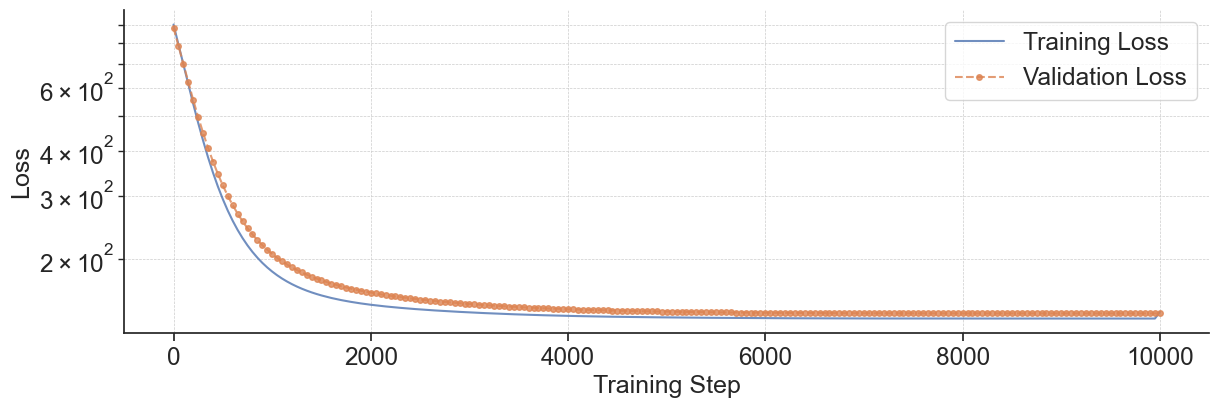

In [5]:
plt.figure(figsize=(14, 4.2))
sns.set_theme(style='ticks', font_scale=1.6, rc={'axes.labelsize':18, 'axes.titlesize':18}) 
plt.semilogy(np.arange(len(losses['training_loss']))*50, losses['training_loss'], label='Training Loss', alpha=0.8, color=sns.color_palette()[0])
plt.semilogy(np.arange(len(losses['validation_loss']))*50, losses['validation_loss'], label='Validation Loss', linestyle='--', marker='o', markersize=4, alpha=0.8, color=sns.color_palette()[1])
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
sns.despine()
plt.show()

In [6]:
params

{'sliding_mlp': {'w': Array([[0.82959735],
         [0.2508082 ],
         [0.21927197],
         [0.35131374],
         [0.79271543],
         [2.088478  ]], dtype=float32)}}

In [7]:
lr_input, lr_output = lr.lr_window_fn(ds_va._xs, ds_va._ys)

model = hk.transform(lr.vmap_forward_fn)

output = model.apply(params, None, lr_input, output_dim=1)

# sample from the output either greedily or with thompson sampling
ll = log_likelihood_normalised(ds_va._ys[1:], output[1:])
parameter_arrays = jax.tree_util.tree_leaves(params)
total_params = jnp.sum(jnp.array([arr.size for arr in parameter_arrays]))
print(f"The log likelihood for logistic regression is {ll:.3f}.")
print(f"The total number of parameters in the network is: {total_params}")

The log likelihood for logistic regression is -0.198.
The total number of parameters in the network is: 6


In [8]:
params

{'sliding_mlp': {'w': Array([[0.82959735],
         [0.2508082 ],
         [0.21927197],
         [0.35131374],
         [0.79271543],
         [2.088478  ]], dtype=float32)}}

In [72]:

sample_type = 'thompson'
y_sampled = switch_utils.sampler(output, sample_type, key=69, sigmoid=True)
print(y_sampled.shape)

(978, 158)


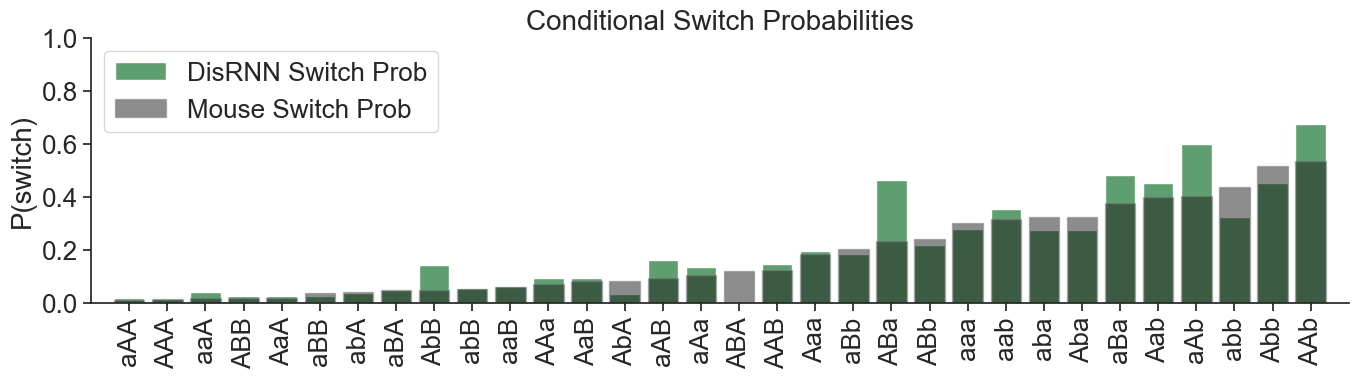

In [73]:
# simulated conditional probability dictionary for each 3 letter history
p_dict = switch_utils.switch_bars(ds_va._xs, ds_va._xs[:,:,0], symm=True, prob=True)
sim_p_dict = switch_utils.switch_bars(ds_va._xs[1:], y_sampled[:-1], symm=True, prob=True)

sorted_items = sorted(p_dict.items(), key=lambda item: item[1])
sorted_keys = [item[0] for item in sorted_items] 
sorted_labels = [item[0] for item in sorted_items]
sorted_heights = [item[1] for item in sorted_items]
sim_sorted_heights = [sim_p_dict[key] for key in sorted_keys]

sns.set(style='ticks', font_scale=1.7, rc={'axes.labelsize':20, 'axes.titlesize':20})
sns.set_palette('deep')


fig, ax = plt.subplots(figsize=(14,4.2))

sns.barplot(x=sorted_labels, y=sim_sorted_heights, color='g', alpha=1, ax=ax, label='DisRNN Switch Prob')
sns.barplot(x=sorted_labels, y=sorted_heights, color='k', alpha=0.5, ax=ax, edgecolor='gray', label='Mouse Switch Prob')

ax.set(xlim=(-1,len(sorted_heights)), ylim=(0,1), ylabel='P(switch)')
plt.xticks(rotation=90)
sns.despine()
plt.title('Conditional Switch Probabilities')
plt.tight_layout()
plt.legend()
# plt.savefig('/Users/michaelcondon/workspaces/pbm_group2/disentangled_rnns/figs/switch_probs.pdf')
plt.show()

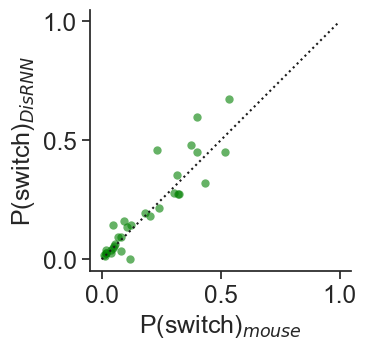

In [74]:
sns.set_theme(style='ticks', font_scale=1.6, rc={'axes.labelsize':18, 'axes.titlesize':18})   
sns.set_palette('dark')

plt.figure(figsize=(4,4))
plt.subplot(111, aspect='equal')
plt.scatter(sorted_heights, sim_sorted_heights, color='green', alpha=0.6, edgecolor=None, linewidth=0)
plt.plot([0, 1], [0, 1], ':k')

plt.xlabel('P(switch)$_{mouse}$')
plt.ylabel('P(switch)$_{DisRNN}$')
plt.xticks(np.arange(0, 1.1, 0.5))
plt.yticks(np.arange(0, 1.1, 0.5))

plt.tight_layout()
sns.despine()

plt.savefig('/Users/michaelcondon/workspaces/pbm_group2/disentangled_rnns/figs/scatter_disrnn_v_mouse.pdf')
plt.show()

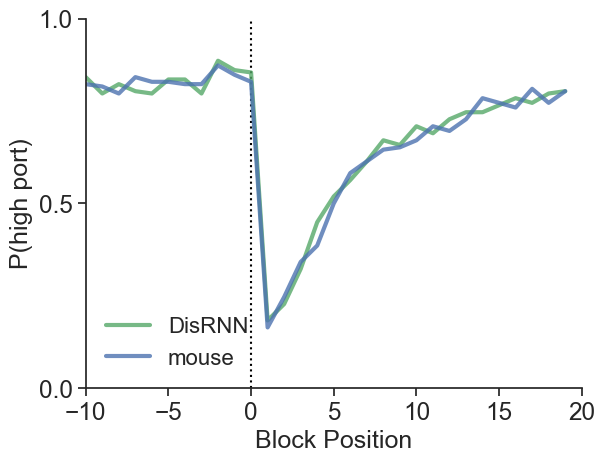

In [75]:
"""
Next, I need to line up the block index in each trial with the switches as
calculated by the samplers.
"""

# ds_va = switch_utils.get_dataset(df[df['Session'].isin(va_eps.index)], va_eps, batch_size)
blocks_sim = switch_utils.blocker(df_va, y_sampled[:-1], ds_va._xs[1:,:,0]!=-1, 10, 20)
blocks = switch_utils.blocker(df_va, ds_va._xs[1:,:,0], ds_va._xs[1:,:,0]!=-1, 10, 20)
block_pos = np.arange(-10,20)
blocks_sim_high = blocks_sim[:,:,:,0] == blocks_sim[:,:,:,1]
blocks_high = blocks[:,:,:,0] == blocks[:,:,:,1]

sns.set_theme(style='ticks', font_scale=1.6, rc={'axes.labelsize':18, 'axes.titlesize':18}) 

fig, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.vlines(x=0,ymin=0,ymax=1.05,linestyle='dotted',color='black')
    
ax1.plot(block_pos, np.mean(blocks_sim_high[:,:,2], axis=1),label='DisRNN', alpha=0.8, linewidth=3, color=sns.color_palette()[2])
ax1.plot(block_pos, np.mean(blocks_high[:,:,2], axis=1),label='mouse', alpha=0.8, linewidth=3, color=sns.color_palette()[0])

ax1.set_yticks([0,0.5, 1.0])
ax1.legend(fontsize=16,frameon=False)
ax1.set(xlim=(-10,20), ylim=(0,1), xlabel='Block Position', ylabel='P(high port)')

sns.despine()

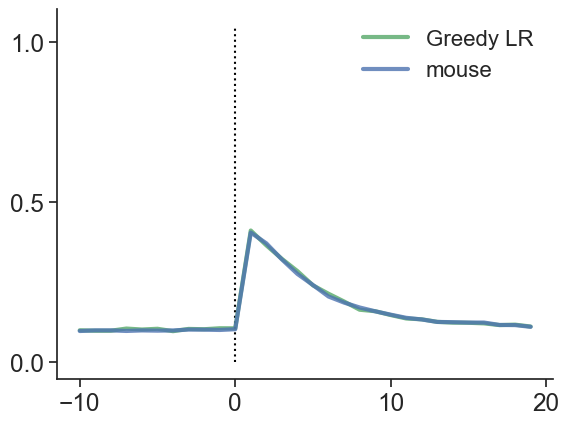

In [76]:
blocks_sim_switch1 = blocks_sim1[1:,:,:,0] != blocks_sim1[:-1,:,:,0]
blocks_sim_switch2 = blocks_sim2[1:,:,:,0] != blocks_sim2[:-1,:,:,0]


blocks_sim = switch_utils.blocker(df_va, y_sampled[:-1], ds_va._xs[1:,:,0]!=-1, 10, 20)
blocks = switch_utils.blocker(df_va, ds_va._ys[:-1,:,0], ds_va._xs[1:,:,0]!=-1, 10, 20)
block_pos = np.arange(-10,20)
blocks_sim_high = blocks_sim[...,0] != blocks_sim[...,1]
blocks_high = blocks[...,0] != blocks[...,1]

sns.set_theme(style='ticks', font_scale=1.6, rc={'axes.labelsize':18, 'axes.titlesize':18}) 

fig, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.vlines(x=0,ymin=0,ymax=1.05,linestyle='dotted',color='black')
    
ax1.plot(block_pos, np.mean(np.mean(blocks_sim_switch[:,:,:], axis=2), axis=1),label='Greedy LR', alpha=0.8, linewidth=3, color=sns.color_palette()[2])
ax1.plot(block_pos, np.mean(np.mean(blocks_switch[:,:,:], axis=2), axis=1),label='mouse', alpha=0.8, linewidth=3, color=sns.color_palette()[0])

ax1.set_yticks([0,0.5, 1.0])
ax1.legend(fontsize=16,frameon=False)
# ax1.set(xlim=(-10,20), ylim=(0,0.5), xlabel='Block Position', ylabel='P(switch)')

sns.despine()

In [45]:
np.shape(blocks_sim)

(30, 158, 27, 2)